# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid

In [3]:
DATA_GRID_INPUT_DIR = '.'

In [4]:
print('Loading the data...')

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [5]:
h = 28 # Prediction horizon
max_lags = 65 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
SEED = 7


In [6]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000


# 2. Feature Engineering

## Creating features


In [7]:
def create_features(df):
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)
               
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
    

In [8]:
%%time

create_features(data)

CPU times: user 2min 32s, sys: 6.31 s, total: 2min 39s
Wall time: 2min 40s


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 33 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   item_id             int16         
 2   dept_id             int8          
 3   store_id            int8          
 4   cat_id              int8          
 5   state_id            int8          
 6   d                   object        
 7   sales               float16       
 8   date                datetime64[ns]
 9   wm_yr_wk            int16         
 10  weekday             int8          
 11  wday                int16         
 12  month               int16         
 13  year                int16         
 14  event_name_1        int8          
 15  event_type_1        int8          
 16  event_name_2        int8          
 17  event_type_2        int8          
 18  snap_CA             float16       
 19  snap_TX             float16       
 20  

In [10]:
data.dropna(inplace = True)
data.shape

(44229047, 33)

In [11]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
713989,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_60,0.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,1.142578,0.928711,3.572266,0.433838,0.967773,13,1,29
713990,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_61,0.0,2011-03-30,11109,6,5,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,0.285645,0.714355,3.572266,0.433350,0.969238,13,1,30
713991,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_62,0.0,2011-03-31,11109,4,6,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,0.000000,0.643066,3.427734,0.432617,0.970703,13,1,31
713992,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_63,0.0,2011-04-01,11109,0,7,4,2011,0,0,0,0,1.0,1.0,0.0,0.419922,0.0,0.0,0.000000,0.000000,0.643066,3.214844,0.431885,0.972168,13,2,1
713996,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_60,2.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,1.769531,9.0,0.0,2.000000,1.571289,2.250000,2.035156,1.597656,1.107422,13,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,1.0,1.000000,0.714355,0.928711,1.250000,3.980469,1.000000,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,0.0,2.0,0.856934,1.142578,1.036133,1.107422,1.280273,1.000000,16,2,23
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,4.0,0.714355,1.571289,1.036133,1.250000,1.280273,1.000000,16,2,24
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,2.285156,1.821289,1.786133,1.000000,1.000000,16,2,23


## Reduce mem usage of created features

In [12]:
data = reduce_mem_usage(data)

Mem. usage decreased to 3290.05 Mb (6.0% reduction)


In [13]:
gc.collect()

80

# 3. Fit & Predict

In [14]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 3.449865666 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
713989,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_60,0.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,1.142578,0.928711,3.572266,0.433838,0.967773,13,1,29
713990,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_61,0.0,2011-03-30,11109,6,5,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,0.285645,0.714355,3.572266,0.433350,0.969238,13,1,30
713991,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_62,0.0,2011-03-31,11109,4,6,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,0.000000,0.643066,3.427734,0.432617,0.970703,13,1,31
713992,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_63,0.0,2011-04-01,11109,0,7,4,2011,0,0,0,0,1.0,1.0,0.0,0.419922,0.0,0.0,0.0,0.000000,0.643066,3.214844,0.431885,0.972168,13,2,1
713996,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_60,2.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,1.769531,9.0,0.0,2.0,1.571289,2.250000,2.035156,1.597656,1.107422,13,1,29


In [15]:
# train_end_dt = datetime(2016, 3, 27)
# valid_end_dt = datetime(2016, 4, 24)

valid_start = datetime(2016, 3, 28)
train_valid_end_dt = datetime(2016, 4, 24)

In [16]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weights"] + \
                ['lag_t1']  # lag_t1 leads to overfitting
train_cols = data.columns[~data.columns.isin(useless_cols)]

X_train = data[train_cols]
y_train = data["sales"]

X_valid= data.loc[(data.date >= valid_start) & (data.date <=train_valid_end_dt), train_cols]
y_valid = data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), "sales"]

del data
gc.collect()

X_train_np = X_train.values.astype(np.float32)
X_valid_np = X_valid.values.astype(np.float32)

del X_train, X_valid
gc.collect()

train_data = lgb.Dataset(X_train_np, label = y_train, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_valid_np, label = y_valid, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)


CPU times: user 5.25 s, sys: 3.15 s, total: 8.4 s
Wall time: 8.51 s


In [17]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': 1,
            'seed': SEED,
} 

In [18]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


[50]	training's rmse: 2.73299	valid_1's rmse: 2.18889
[100]	training's rmse: 2.48067	valid_1's rmse: 2.00133
[150]	training's rmse: 2.42902	valid_1's rmse: 1.97953
[200]	training's rmse: 2.39547	valid_1's rmse: 1.96676
[250]	training's rmse: 2.37323	valid_1's rmse: 1.9574
[300]	training's rmse: 2.3578	valid_1's rmse: 1.95128
[350]	training's rmse: 2.34601	valid_1's rmse: 1.94634
[400]	training's rmse: 2.33524	valid_1's rmse: 1.94134
[450]	training's rmse: 2.32596	valid_1's rmse: 1.93689
[500]	training's rmse: 2.31781	valid_1's rmse: 1.93311
[550]	training's rmse: 2.31009	valid_1's rmse: 1.92887
[600]	training's rmse: 2.30246	valid_1's rmse: 1.92528
[650]	training's rmse: 2.29616	valid_1's rmse: 1.92199
[700]	training's rmse: 2.28951	valid_1's rmse: 1.91899
[750]	training's rmse: 2.28357	valid_1's rmse: 1.9157
[800]	training's rmse: 2.27827	valid_1's rmse: 1.91296
[850]	training's rmse: 2.27304	valid_1's rmse: 1.91044
[900]	training's rmse: 2.26714	valid_1's rmse: 1.90715
[950]	training

In [19]:
os.system('say "Training complete"')

0

In [20]:
m_lgb.save_model("model.lgb")
#m_lgb = lgb.Booster(model_file='model.lgb')

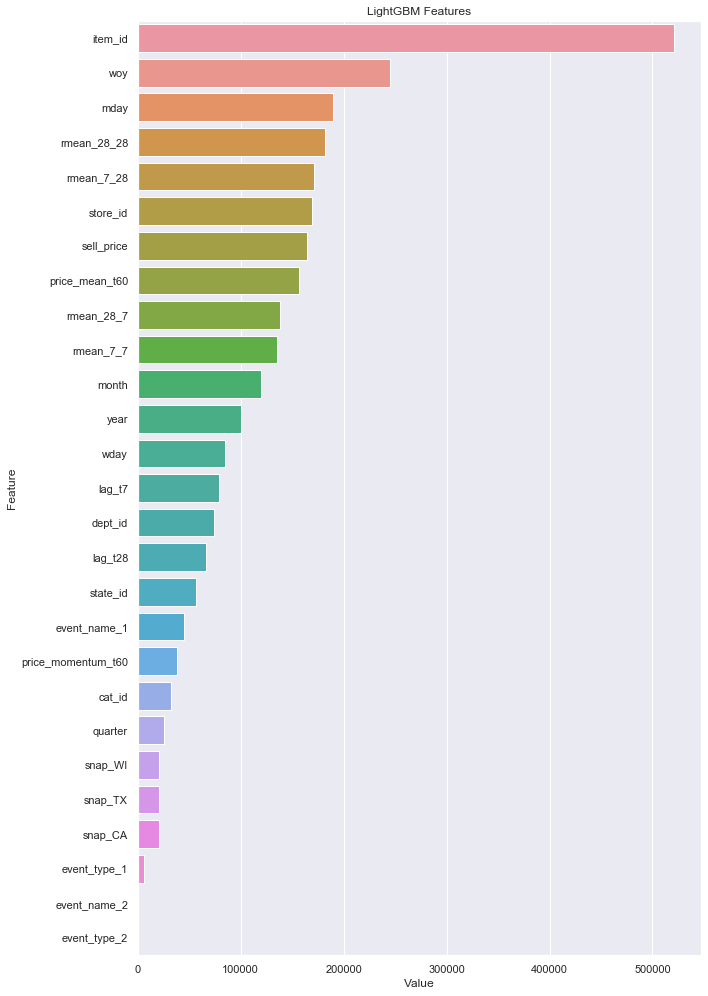

In [21]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance(), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [22]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
0,521333,item_id
24,244869,woy
26,189383,mday
21,182339,rmean_28_28
20,170834,rmean_7_28
2,168929,store_id
15,164820,sell_price
22,156767,price_mean_t60
19,138423,rmean_28_7
18,134968,rmean_7_7


In [30]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

CPU times: user 225 ms, sys: 190 ms, total: 415 ms
Wall time: 605 ms


In [31]:
def create_lag_features_for_test(df, day):
    # create lag feaures just for single day (faster)
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main

    windows = [7, 28]
    for window in windows:
        for lag in lags:
            df_window = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+window))]
            df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{window}"] = df_window_grouped.sales.values     
    
    
## Creating features for test data
def create_date_features_for_test(df):
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")
            
    # Create price features
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)


In [32]:
create_date_features_for_test(tdata)

In [33]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    
    # Check that all features generated correctly
    if tst[tst.isna().any(axis=1)].shape[0] > 0:
        print('Some values in tst are nans:')
        print(tst[tst.isna().any(axis=1)])
        
    tdata.loc[tdata.date == day, "sales"] = 1.035 * m_lgb.predict(tst.values.astype(np.float32)) 


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 38min 54s, sys: 16.7 s, total: 39min 11s
Wall time: 11min 35s


In [34]:
os.system('say "Prediction complete"')

0

In [35]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id                    144959
item_id               144959
dept_id               144959
store_id              144959
cat_id                144959
state_id              144959
d                     144959
sales                 144959
date                  144959
wm_yr_wk              144959
weekday               144959
wday                  144959
month                 144959
year                  144959
event_name_1          144959
event_type_1          144959
event_name_2          144959
event_type_2          144959
snap_CA               144959
snap_TX               144959
snap_WI               144959
sell_price            144959
woy                   144959
quarter               144959
mday                  144959
price_mean_t60        144959
price_momentum_t60    144959
dtype: int64

In [36]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.03

tdata_sub.to_csv("submission_1.csv",index=False)
tdata_sub.shape


CPU times: user 3.98 s, sys: 260 ms, total: 4.24 s
Wall time: 4.53 s


(60980, 29)